Vítejte u domácí úlohy do SUI.
V rámci úlohy Vás čeká několik cvičení, v nichž budete doplňovat poměrně malé fragmenty kódu, místo na ně je vyznačené jako `pass` nebo `None`.
Pokud se v buňce s kódem již něco nachází, využijte/neničte to.
V dvou případech se očekává textová odpověď, tu uvedete přímo do zadávající buňky.
Buňky nerušte ani nepřidávejte.

Maximálně využívejte `numpy` a `torch` pro hromadné operace na celých polích.
S výjimkou generátoru minibatchí by se nikde neměl objevit cyklus jdoucí přes jednotlivé příklady.

U všech cvičení je uveden počet bodů za funkční implementaci a orientační počet potřebných řádků.
Berte ho prosím opravdu jako orientační, pozornost mu věnujte pouze, pokud ho významně překračujete.
Mnoho zdaru!

# Informace o vzniku řešení
Vyplňte následující údaje **(3 údaje, 0 bodů)**

* Jméno autora: Filip Jeřábek
* Login autora: xjerab24
* Datum vzniku: 21.10.2020

In [25]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import scipy.stats

# Přípravné práce
Prvním úkolem v této domácí úloze je načíst data, s nimiž budete pracovat.
Vybudujte jednoduchou třídu, která se umí zkonstruovat z cesty k negativním a pozitivním příkladům, a bude poskytovat:
- pozitivní a negativní příklady (`dataset.pos`, `dataset.neg` o rozměrech [N, 7])
- všechny příklady a odpovídající třídy (`dataset.xs` o rozměru [N, 7], `dataset.targets` o rozměru [N])

K načítání dat doporučujeme využít `np.loadtxt()`.
Netrapte se se zapouzdřování a gettery, berte třídu jako Plain Old Data.

Načtěte trénovací (`{positives,negatives}.trn`), validační (`{positives,negatives}.val`) a testovací (`{positives,negatives}.tst`) dataset, pojmenujte je po řadě (`train_dataset`, `val_dataset`, `test_dataset`). 

**(6+3 řádků, 1 bod)** 


In [26]:
class DataClass:
  def __init__(self, positives, negatives):
    self.pos = np.loadtxt(positives)
    self.neg = np.loadtxt(negatives)
    self.xs = np.vstack((self.pos, self.neg))
    self.targets = np.hstack((np.ones(len(self.pos)), np.zeros(len(self.neg))))

train_dataset = DataClass("./positives.trn", "./negatives.trn")
val_dataset = DataClass("./positives.val", "./negatives.val")
test_dataset = DataClass("./positives.tst", "./negatives.tst")

print('positives', train_dataset.pos.shape)
print('negatives', train_dataset.neg.shape)
print('xs', train_dataset.xs.shape)
print('targets', train_dataset.targets.shape)

positives (2280, 7)
negatives (6841, 7)
xs (9121, 7)
targets (9121,)


V řadě následujících cvičení budete pracovat s jedním konkrétním příznakem. Naimplementujte pro začátek funkci, která vykreslí histogram rozložení pozitivních a negativních příkladů (`plt.hist()`). Nezapomeňte na legendu, ať je v grafu jasné, které jsou které. Funkci zavolejte dvakrát, vykreslete histogram příznaku `5` -- tzn. šestého ze sedmi -- pro trénovací a validační data **(5 řádků, 1 bod)**.

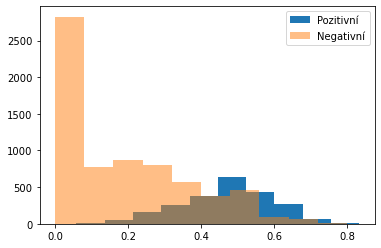

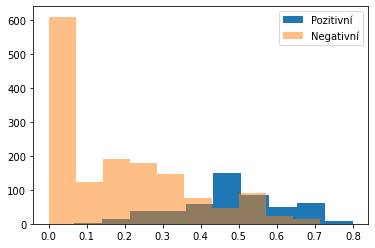

In [27]:
FOI = 5  # Feature Of Interest

def plot_data(poss, negs):
    plt.hist(poss)
    plt.hist(negs, alpha=0.5)
    plt.legend(["Pozitivní", "Negativní"])
    plt.show()

plot_data(train_dataset.pos[:, FOI], train_dataset.neg[:, FOI])
plot_data(val_dataset.pos[:, FOI], val_dataset.neg[:, FOI])

### Evaluace klasifikátorů
Než přistoupíte k tvorbě jednotlivých klasifikátorů, vytvořte funkci pro jejich vyhodnocování.
Nechť se jmenuje `evaluate` a přijímá po řadě klasifikátor, pole dat (o rozměrech [N] nebo [N, F]) a pole tříd ([N]).
Jejím výstupem bude _přesnost_, tzn. podíl správně klasifikovaných příkladů.

Předpokládejte, že klasifikátor poskytuje metodu `.prob_class_1(data)`, která vrací pole posteriorních pravděpodobností třídy 1 (tj. p(y=1|x)) pro daná data.
Evaluační funkce bude muset provést tvrdé prahování (na hodnotě 0.5) těchto pravděpodobností a srovnání získaných rozhodnutí s referenčními třídami.
Využijte fakt, že `numpy`ovská pole lze mj. porovnávat mezi sebou i se skalárem.

**(3 řádky, 1 bod)**

In [28]:
def evaluate(classifier, inputs, targets):
    guessed = np.round(classifier.prob_class_1(inputs))
    match = guessed == targets
    return np.average(match)


class Dummy:
    def prob_class_1(self, xs):
        return np.asarray([0.2, 0.7, 0.7])

print(evaluate(Dummy(), train_dataset.xs, np.asarray([0, 0, 1])))  # should be 0.66...

0.6666666666666666


### Baseline
Vytvořte klasifikátor, který ignoruje vstupní hodnotu dat.
Jenom v konstruktoru dostane třídu, kterou má dávat jako tip pro libovolný vstup.
Nezapomeňte, že jeho metoda `.prob_class_1(data)` musí vracet pole správné velikosti, využijte `np.ones` nebo `np.full`.

**(4 řádky, 1 bod)**

In [29]:
class PriorClassifier:
    def __init__(self, class_type):
        self.guessed = class_type
    def prob_class_1(self, xs):
        return np.full(len(xs),self.guessed)

baseline = PriorClassifier(0)
val_acc = evaluate(baseline, val_dataset.xs[:, FOI], val_dataset.targets)
print('Baseline val acc:', val_acc)

Baseline val acc: 0.75


# Generativní klasifikátory
V této  části vytvoříte dva generativní klasifikátory, oba založené na Gaussovu rozložení pravděpodobnosti.

Začněte implementací funce, která pro daná 1-D data vrátí Maximum Likelihood odhad střední hodnoty a směrodatné odchylky Gaussova rozložení, které data modeluje.
Funkci využijte pro natrénovaní dvou modelů: pozitivních a negativních příkladů.
Získané parametry -- tzn. střední hodnoty a směrodatné odchylky -- vypište.

**(5 řádků, 0.5 bodu)**

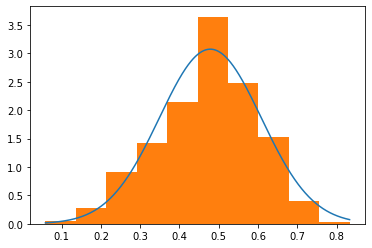

In [30]:


def generative_clasification_1(data):
    mi = 1/len(data) * sum(data)
    ro = np.sqrt(1/len(data) * sum(np.square(np.subtract(data,mi))))
    return [mi,ro]

# pro kontrolu
def graph_check(mi,ro, data):
    x_axis = np.arange(np.min(data), np.max(data), 0.001)
    plt.plot(x_axis, scipy.stats.norm.pdf(x_axis,mi,ro))
    plt.hist(data, density=True)
    plt.show()

returned = generative_clasification_1(train_dataset.pos[:, FOI])
graph_check(returned[0], returned[1], train_dataset.pos[:, FOI])

Ze získaných parametrů vytvořte `scipy`ovská gaussovská rozložení `scipy.stats.norm`.
S využitím jejich metody `.pdf()` vytvořte graf, v němž srovnáte skutečné a modelové rozložení pozitivních a negativních příkladů.
Rozsah x-ové osy volte od -0.5 do 1.5 (využijte `np.linspace`) a u volání `plt.hist()` nezapomeňte nastavit `density=True`, aby byl histogram normalizovaný a dal se srovnávat s modelem.

**(2+8 řádků, 1 bod)**

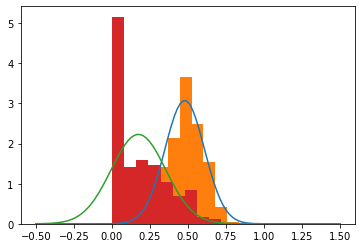

In [31]:
def make_graph(mi1, ro1, data1, mi2, ro2, data2):
    x_axis = np.arange(np.min(data1), np.max(data1), 0.001)
    linsp = np.linspace(-0.5,1.5,100)
    plt.plot(linsp, scipy.stats.norm.pdf(linsp,mi1,ro1))
    plt.hist(data1, density=True)
    x_axis = np.arange(np.min(data2), np.max(data2), 0.001)
    plt.plot(linsp, scipy.stats.norm.pdf(linsp,mi2,ro2))
    plt.hist(data2, density=True)
    plt.show()

returned1 = generative_clasification_1(train_dataset.pos[:, FOI])
returned2 = generative_clasification_1(train_dataset.neg[:, FOI])
make_graph(returned1[0], returned1[1], train_dataset.pos[:, FOI], returned2[0], returned2[1], train_dataset.neg[:, FOI])

Naimplementujte binární generativní klasifikátor. 
Při konstrukci přijímá dvě rozložení poskytující metodu `.pdf()` a odpovídající apriorní pravděpodobnost tříd.
Jako všechny klasifikátory v této domácí úloze poskytuje metodu `prob_class_1()`.

**(9 řádků, 2 body)**

In [32]:
class binary_gener_clasif_class:
    def __init__(self, layout1, layout2, class_prob1):
        self.layout1 = layout1
        self.layout2 = layout2
        self.class_prob1 = 1- class_prob1
        self.class_prob2 = class_prob1
    def prob_class_1(self, values):
        gaus1 = self.layout1.pdf(values) * self.class_prob1
        gaus2 = self.layout2.pdf(values) * self.class_prob2
        return gaus1 / (gaus1 + gaus2)

my_gaus1 = scipy.stats.norm(returned1[0], returned1[1])
my_gaus2 = scipy.stats.norm(returned2[0], returned2[1])

bin_gen_clasif_ins = binary_gener_clasif_class(my_gaus1, my_gaus2, 0.5)
# bin_gen_ret = bin_gen_clasif_ins.prob_class_1(train_dataset.pos[:, FOI])
bin_gen_ret = bin_gen_clasif_ins.prob_class_1(train_dataset.pos[:, FOI])


Test output
[0.94539033 0.52246093 0.84790297 ... 0.83191963 0.95478294 0.87671753]


Nainstancujte dva generativní klasifikátory: jeden s rovnoměrnými priory a jeden s apriorní pravděpodobností 0.75 pro třídu 0 (negativní příklady).
Pomocí funkce `evaluate()` vyhodnoťte jejich úspěšnost na validačních datech.

**(2 řádky, 1 bod)**

In [33]:
classifier_flat_prior = binary_gener_clasif_class(my_gaus1, my_gaus2, 0.5)
classifier_full_prior = binary_gener_clasif_class(my_gaus1, my_gaus2, 0.75)

print('flat:', evaluate(classifier_flat_prior, val_dataset.xs[:, FOI], val_dataset.targets))
print('full:', evaluate(classifier_full_prior, val_dataset.xs[:, FOI], val_dataset.targets))

flat: 0.809
full: 0.8475


Vykreslete průběh posteriorní pravděpodobnosti třídy 1 jako funkci příznaku 5 pro oba klasifikátory, opět v rozsahu <-0.5; 1.5>.
Do grafu zakreslete i histogramy rozložení trénovacích dat, opět s `density=True` pro zachování dynamického rozsahu.

**(8 řádků, 1 bod)**

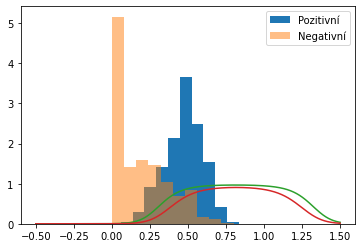

In [34]:
linsp = np.linspace(-0.5,1.5,len(train_dataset.pos[:, FOI]))
bin_gen_ret_1 = classifier_flat_prior.prob_class_1(linsp)
bin_gen_ret_2 = classifier_full_prior.prob_class_1(linsp)

plt.hist(train_dataset.pos[:, FOI], density=True)
plt.hist(train_dataset.neg[:, FOI], density=True, alpha=0.5)
plt.legend(["Pozitivní", "Negativní"])
plt.plot(linsp, bin_gen_ret_1)
plt.plot(linsp, bin_gen_ret_2)
plt.show()


Interpretujte, přímo v této textové buňce, každou rozhodovací hranici, která je v grafu patrná **(3 věty, 2 body)**:

Osa y udává dle klasifikátoru pravděpodobnost, že vzorek (na ose x) patří do třídy 1.
Tato pravděpodobnost se řídí dvěma gausovými rozloženími, které jsem vytvořil v předchozích příkladech. Poměrem jejich
velikostí v daném bodě.
Což je přesně vykresleno v tomto grafu. Červená křivka má pomalejší nárůst a rychlejší klesání kvůli tomu, že klasifikátor
má pro třídu 1 menší prioritu.
Poté křivky klesají (což jsem zprvu nechápal), to je způsobeno tím, že gaussova křivka pro třídu 0 klesá do 0 v nekonečnu pomaleji,
než gaussovka pro třídu 1. Ty se někde v hodnotě mezi 1.2 a 1.4 na ose x protnou a gaussovka pro třídu 0 začíná nabývat větší hodnoty.
Proto křivka posteriorní pravděpodobnosti třídy klesne.

# Diskriminativní klasifikátory
V následující části budete přímo modelovat posteriorní pravděpodobnost třídy 1.
Modely budou založeny na PyTorchi, ten si prosím nainstalujte.
GPU rozhodně nepotřebujete, veškeré výpočty budou velmi rychlé, ne-li bleskové.

Do začátku máte poskytnutou třídu klasifikátoru z jednoho příznaku.

In [35]:
import torch

import torch.nn.functional as F

class LogisticRegression(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.w = torch.nn.parameter.Parameter(torch.tensor([1.0]))
        self.b = torch.nn.parameter.Parameter(torch.tensor([0.0]))
        
    def forward(self, x):
        return torch.sigmoid(self.w*x + self.b)
    
    def prob_class_1(self, x):
        prob = self(torch.from_numpy(x))
        return prob.detach().numpy()

Pro trénovaní diskriminativních modelů budete potřebovat minibatche.
Implementujte funkci, která je bude z daných vstupních a cílových hodnot vytvářet.
Výsledkem musí být možno iterovat, ideálně funkci napište jako generátor (využijte klíčové slovo `yield`).
Jednotlivé prvky výstupu budou dvojice PyTorchových `FloatTensor`ů (musíte zkonvertovat z numpy a nastavit typ) -- první prvek vstupní data, druhý očekávané výstupy.
Počítejte s tím, že vstup bude `numpy`ovské pole, rozumná implementace využije `np.random.permutation()` a [Advanced Indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html).

Připravený kód funkci použije na konstrukci tří minibatchí pro trénování identity, měli byste vidět celkem pět prvků náhodně uspořádaných do dvojic, ovšem s tím, že s sebou budou mít odpovídající výstupy.

**(6 řádků, 2 body)**

In [72]:
def batch_provider(xs, targets, batch_size=10):
    indexes = []
    cycle_len = 0
    for i in np.random.permutation(range(len(xs))):
        cycle_len += 1
        indexes.append(i)
        if (len(indexes) == batch_size) or (cycle_len == len(xs)):
            left = []
            right = []
            tmp_indexes = indexes
            indexes = []
            for j in range(len(tmp_indexes)):
                left.append(xs[tmp_indexes[j]])
                right.append(targets[tmp_indexes[j]])
            yield torch.Tensor(left), torch.Tensor(right)


inputs = np.asarray([1.0, 2.0, 3.0, 4.0, 5.0])
targets = np.asarray([1.0, 2.0, 3.0, 4.0, 5.0])
for x, t in batch_provider(inputs, targets, 2):
    print(f'x: {x}, t: {t}')

x: tensor([1., 5.]), t: tensor([1., 5.])
x: tensor([4., 3.]), t: tensor([4., 3.])
x: tensor([2.]), t: tensor([2.])


Dalším krokem je implementovat funkci, která model vytvoří a natrénuje.
Jejím výstupem bude (1) natrénovaný model, (2) průběh trénovací loss a (3) průběh validační přesnosti.
Jako model vracejte ten, který dosáhne nejlepší validační přesnosti.
Jako loss použijte binární cross-entropii (`F.binary_cross_entropy()`), akumulujte ji přes minibatche a logujte průměr.
Pro výpočet validační přesnosti využijte funkci `evaluate()`.
Oba průběhy vracejte jako obyčejné seznamy.

V implementaci budete potřebovat dvě zanořené smyčky: jednu pro epochy (průchody přes celý dataset) a uvnitř druhou, která bude iterovat přes jednotlivé minibatche.
Na konci každé epochy vyhodnoťte model na validačních datech.
K datasetům (trénovacímu a validačnímu) přistupujte bezostyšně jako ke globálním proměnným.

**(cca 14 řádků, 3 body)**

In [37]:
def train_single_fea_llr(fea_no, nb_epochs, lr, batch_size):
    ''' fea_no -- which feature to train on
        nb_epochs -- how many times to go through the full training data
        lr -- learning rate
        batch_size -- size of minibatches
    '''
    model = LogisticRegression()
    best_model = copy.deepcopy(model)
    losses = []
    accuracies = []
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    for i in range(nb_epochs):
        batch_looses = []
        for x, t in batch_provider(train_dataset.xs[:, fea_no],
                                   train_dataset.targets, batch_size):
            optimizer.zero_grad()
            lss = F.binary_cross_entropy(model(x),t)
            batch_looses.append(lss)
            lss.backward()
            optimizer.step()
        losses.append(torch.mean(torch.stack(batch_looses)))
        eval_ret = evaluate(model, val_dataset.xs[:, fea_no], val_dataset.targets)
        if all(i < eval_ret for i in accuracies):
            best_model = copy.deepcopy(model)
        accuracies.append(eval_ret)



    return best_model, losses, accuracies


Funkci zavolejte a natrénujte model.
Uveďte zde parametry, které vám dají slušný výsledek.
Měli byste dostat přesnost srovnatelnou s generativním klasifikátorem s nastavenými priory.
Neměli byste potřebovat víc než 100 epoch.
Vykreslete průběh trénovací loss a validační přesnosti, osu x značte v epochách.

V druhém grafu vykreslete histogramy trénovacích dat a pravděpodobnost třídy 1 pro x od -0.5 do 1.5, podobně jako výše u generativních klasifikátorů.
Při výpočtu výstupů využijte `with torch.no_grad():`.
**(1 + 6 + 9 řádků, 1 bod)**

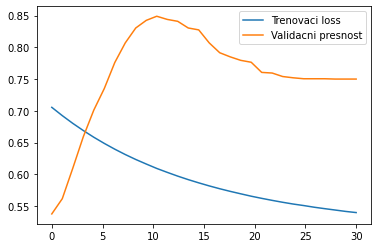

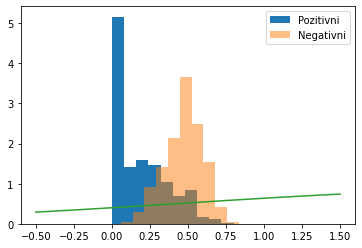

In [95]:
epoch = 30

model, losses, accuracies = train_single_fea_llr(FOI, epoch, 0.001, 64)
x = np.linspace(0,epoch,epoch)
plt.plot(x, losses)

x = np.linspace(0,epoch,epoch)
plt.plot(x, accuracies)

plt.legend(["Trenovaci loss", "Validacni presnost"])
plt.show()

# x = np.linspace(0, len(train_dataset.xs[:, FOI]), len(train_dataset.xs[:, FOI]))
linsp = np.linspace(-0.5,1.5,len(train_dataset.pos[:, FOI]))
model_ret_1 = model.prob_class_1(linsp)

with torch.no_grad():
    plt.hist(train_dataset.neg[:, FOI], density=True)
    plt.hist(train_dataset.pos[:, FOI], density=True, alpha= 0.5)
    plt.legend(["Pozitivni", "Negativni"])
    plt.plot(linsp, model_ret_1)
    plt.show()

## Všechny vstupní příznaky
V posledním cvičení natrénujete logistickou regresi, která využije všech sedm vstupních příznaků.

Prvním krokem je naimplementovat příslusný model.
Bezostyšně zkopírujte tělo třídy `LogisticRegresion` a upravte ji tak, aby zvládala libovolný počet vstupů, využijte `torch.nn.Linear`.
U výstupu metody `.forward()` dejte pozor, aby měl výstup tvar `[N]`; pravděpodobně budete potřebovat `squeeze`.

**(9 řádků, 1 bod)**

In [39]:
class LogisticRegressionAll(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.lin = torch.nn.Linear(in_dim, out_dim)

    def forward(self, x):
        return np.squeeze(torch.sigmoid(self.lin(x)))

    def prob_class_1(self, x):
        prob = self(torch.from_numpy(x).float())
        return prob.detach().numpy()

Podobně jako u jednodimenzionálni regrese implementujte funkci pro trénovaní plné logistické regrese.
V ideálním případě vyfaktorujete společnou implementaci, které budete pouze předávat různá trénovací a validační data.

Zvídaví mohou zkusit `Adam`a jako optimalizátor namísto obyčejného `SGD`.

Funkci zavolejte, natrénujte model.
Opět vykreslete průběh trénovací loss a validační přesnosti.
Měli byste se s přesností dostat nad 90 %.

**(ne víc než cca 30 řádků při kopírování, 1 bod)**
evalie

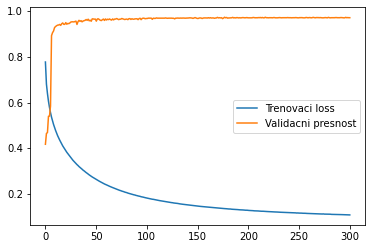

In [89]:
def train_single_fea_llr_all(nb_epochs, lr, batch_size, in_dim, out_dim):
    ''' fea_no -- which feature to train on
        nb_epochs -- how many times to go through the full training data
        lr -- learning rate
        batch_size -- size of minibatches
    '''
    model = LogisticRegressionAll(in_dim,out_dim)
    best_model = copy.deepcopy(model)
    losses = []
    accuracies = []
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    for i in range(nb_epochs):
        batch_looses = []
        for x, t in batch_provider(train_dataset.xs,
                                   train_dataset.targets, batch_size):
            optimizer.zero_grad()
            lss = F.binary_cross_entropy(model(x),t)
            batch_looses.append(lss)
            lss.backward()
            optimizer.step()
        losses.append(torch.mean(torch.stack(batch_looses)))
        eval_ret = evaluate(model, val_dataset.xs, val_dataset.targets)
        if all(i < eval_ret for i in accuracies):
            best_model = copy.deepcopy(model)
        accuracies.append(eval_ret)

    return best_model, losses, accuracies


epoch = 300


model_all, losses, accuracies = train_single_fea_llr_all(epoch, 0.001, 64, 7, 1)
x = np.linspace(0,epoch,epoch)
plt.plot(x, losses)

x = np.linspace(0,epoch,epoch)
plt.plot(x, accuracies)

plt.legend(["Trenovaci loss", "Validacni presnost"])
plt.show()

# Závěrem
Konečně vyhodnoťte všech pět vytvořených klasifikátorů na testovacích datech. Stačí doplnit jejich názvy a předat jim příznaky, na které jsou zvyklé.

**(0.5 bodu)**

In [96]:
epoch = 300

xs_full = test_dataset.xs
xs_foi = test_dataset.xs[:, FOI]
targets = test_dataset.targets

print('Baseline:', evaluate(baseline, xs_foi, targets))
print('Generative classifier (w/o prior):', evaluate(classifier_flat_prior, xs_foi, targets))
print('Generative classifier (correct):', evaluate(classifier_full_prior, xs_foi, targets))
print('Logistic regression:', evaluate(model, xs_foi, targets))
print('logistic regression all features:', evaluate(model_all, xs_full, targets))

Baseline: 0.75
Generative classifier (w/o prior): 0.8
Generative classifier (correct): 0.847
Logistic regression: 0.847
logistic regression all features: 0.9685


Blahopřejeme ke zvládnutí domácí úlohy! Notebook spusťte načisto (Kernel -> Restart & Run all), vyexportuje jako PDF a odevzdejte pojmenovaný svým loginem.

Mimochodem, vstupní data nejsou synteticky generovaná. Nasbírali jsme je z projektu; Vaše klasifikátory v této domácí úloze predikují, že daný hráč vyhraje; takže by se daly použít jako heuristika pro ohodnocování listových uzlů ve stavovém prostoru hry.
Pro představu, odhadujete to z pozic pět kol před koncem partie pro daného hráče.
Poskytnuté příznaky popisují globální charakteristiky stavu hry jako je například poměr délky hranic předmětného hráče k ostatním hranicím.